## สำรวจความนิยมของเหล่าไอดอล BNK48 แบบ real-time จาก Twitter's hashtags ด้วย Python

สำรวจความนิยมของเหล่าไอดอล BNK48 แบบ real-time จาก Twitter's hashtags ด้วย Python
สำหรับคนที่สนใจเพียงแค่ผลการจับลำดับความนิยมของสาวๆ BNK48 ที่ได้จาก code ก็อ่านเพียงแค่หัวข้อนี้กับหัวข้อถัดไปและข้ามไปดูส่วน conclusion ที่มีตัว video บันทึกภาพการจัดลำดับความนิยมของสมาชิกวงจากการทำ Twitter streaming ที่ส่วนล่างสุดของ post นะครับ

post นี้จะไม่ลงรายละเอียดมาก เหมาะสำหรับผู้เขียน Python เป็นอยู่แล้ว และอยากศึกษาการทำ data streaming แบบง่ายๆ โดยเป็นการแสดงตัวอย่างขั้นตอน ในการใช้ Python

1. การดึงข้อมูลจาก Twitter
2. การ Streaming และการจัดการข้อมูล
3. การทำหน้าจอแสดงผลแบบ realtime อย่างง่ายๆ

ขั้นตอนส่วนที่ 1 นั้น นำมาจากจากคอร์ส [Spark and Python for Big Data with PySpark](https://www.udemy.com/spark-and-python-for-big-data-with-pyspark/) บน [Udemy](https://www.udemy.com/) 

ขั้นตอนที่ 2, 3 ในที่นี้ใช้ internal Python networking interface -- สำหรับผู้สนใจตัวอย่าง code ที่ทำแบบเดียวกันโดยใช้ PySpark ดูได้ที่ XXXXXXXXXXXXXXXXXXXXX

ปล. ขอบคุณพี่ต้า ([Ta Virot Chiraphadhanakul](https://www.facebook.com/ta.chiraphadhanakul)) แห่ง [Skoodio](https://www.facebook.com/skooldio/) ที่ช่วยอ่านและให้ feedback ของ draft แรก ด้วยครับ

## Twitter กับ BNK48
คาดว่าทุกคนรู้จัก Twitter กันอยู่แล้ว ก็ขอเพิ่มเติมเพียงว่า Twitter นี่เป็น platform ที่เหมาะกับผู้ที่อยากฝึกทำ data streaming มากๆ ทั้งเรื่อง API support และ supply of data ที่ล้นเหลือ

จากนั้นผู้เขียนก็มาคิดดูว่า data ชุดไหนที่น่าสนใจจะดึงมาลองเล่นดูและมีผู้พูดถึงอยู่เรื่อยๆ (continuous supply of data) ก็สรุปว่าจะเลือกสำรวจข้อความบน Twitter (tweets) ที่เกี่ยวกับกลุ่มไอดอลหญิงของไทยที่มาแรงและมีกลุ่มผู้ติดตามใน Twitter เป็นจำนวนมาก ไอดอลกลุ่มนี้ก็คือ BNK48

ทีนี้เราก็มารู้จักกับสาวๆ BNK48 กันสักเล็กน้อย สั้นๆ ก็คือ -- "BNK48 เป็นกลุ่มไอดอลหญิงของประเทศไทย และเป็นวงน้องสาวของกลุ่มไอดอลญี่ปุ่น AKB48 ภายใต้แนวคิดร่วมกันคือ "ไอดอลที่คุณสามารถไปพบได้" (จาก [Wikipedia](https://th.wikipedia.org/wiki/%E0%B8%9A%E0%B8%B5%E0%B9%80%E0%B8%AD%E0%B9%87%E0%B8%99%E0%B9%80%E0%B8%84%E0%B9%82%E0%B8%9F%E0%B8%A3%E0%B9%8C%E0%B8%95%E0%B8%B5%E0%B9%80%E0%B8%AD%E0%B8%95)) 

ฝากภาพเหล่าสมาชิก BNK48 ไว้เป็นที่ระลึก(ขอบคุณภาพจาก http://www.metalbridges.com/bnk48/)
![BNK48](BNK48.jpg)


## Techical part 0 -- Workflow

ก่อนเริ่มส่วน technical ก็มาดู workflow กันก่อน สั้นๆ เราก็จะทำการ 
1. ดึงข้อมูลจาก Twitter ด้วย Tweepy
2. เชื่อมต่อและเรียกข้อมูล Tweet streaming
3. จัดลำดับ hashtags และทำหน้าจอแสดงผลแบบ real-time อย่างง่ายๆ

**environment ที่ใช้**
* python 3.5.2
* jupyter 4.4.0
* tweepy 3.5.0
* pandas 0.21.0
* matplotlib 2.1.0

## Techical part 1 -- ดึงข้อมูลจาก Twitter ด้วย Tweepy

สำหรับผู้ที่ไม่เคยมี account กับ Twitter ก่อนอื่นก็ต้องสร้าง Twitter account ก่อนนะครับ

เมื่อมี Twitter account แล้ว ก็เข้าไปที่นี่ https://apps.twitter.com/ แล้วก็ login ตามกระบวนการปกติครับ จะเห็นหน้าต่างประมาณนี้

<img src="twitterApp_01.png" alt="twitterApp_firstPage" style="width: 700px;"/>

จากนั้นก็เลือก **Create New App** เพื่อสร้างตัว Twitter app ที่เราจะใช้เป็นตัวกลางในการ Streaming ข้อมูล จาก Twitter -- เติมแค่ fields ที่จำเป็นต้องเติมก็พอ (ตรง Website ใส่เว็บตัวเองหรือ placeholder เช่น https://www.google.com ไปก็ได้)

<img src="twitterApp_02.png" alt="twitterApp_createApp" style="width: 700px;"/>

เมื่อสร้าง app แล้ว ก็เข้าไปดูใน app นั้น จากนั้นเลือก **Keys and Access Tokens** โดยในหน้านี้จะมี 4 fields ที่เราจะนำค่าออกมาใช้ผูกกับ code ของเราเพื่อเรียกข้อมูล ประกอบด้วย Consumer Key (API Key), Consumer Secret (API Secret), Access Token, Access Token Secret

<img src="twitterApp_03.png" alt="twitterApp_keys" style="width: 700px;"/>

#### หลังจากนั้นก็สร้างและบันทึก a Python script ตามไฟล์ที่แนบไว้นี้ครับ (ในตัวอย่างตั้งชื่อว่า streamingTwitterTags.py)

ส่วนที่แต่ละคนต้องปรับเองคือ บรรทัดที่ 12-15 โดยเติม consumer_key, consumer_secret, access_token, และ access_secret ของตัวเองลงไปครับ (บรรทัดที่ 54 จะเปลี่ยนหรือไม่เปลี่ยนก็ตามสะดวกครับ, บรรทัดที่ 52 ก็ต้องเปลี่ยนหากไม่ต้องการให้ script ประมวลบน local host ครับ, บรรทัดที่ 45 ตั้งเป็น 'bnk48' ที่เราจะใช้เป็น keyword สำหรับคัดกรอง)

In [ ]:
# create a file -- streamingTwitterTags.py

# import modules
import tweepy
from tweepy import OAuthHandler, Stream
from tweepy.streaming import StreamListener
import socket
import json


# create credential variables
consumer_key = 'your_consumer_key'        # put your consumer_key from Twitter API
consumer_secret = 'your_consumer_secret'  # put your consumer_secret from Twitter API
access_token = 'your_access_token'        # put your access_token from Twitter API
access_secret = 'your_access_secret'      # put your access_secret from Twitter API

# create a class that listens to tweets
class TweetListener(StreamListener):
    def __init__(self, csocket):
        self.client_socket = csocket
        
    def on_data(self, data):
        try:
            msg = json.loads(data)
            print(msg['text'].encode('utf-8'))
            self.client_socket.send(msg['text'].encode('utf-8'))
            return True
        except BaseException as e:
            print('Error', e)
        return True
    
    def on_error(self, status):
        print(status)
        return True


# create a function that operate on streamed data
def sendData(c_socket):
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    twitter_stream = Stream(auth, TweetListener(c_socket))
    # set a filter to track tweets with a string in the filter set
    twitter_stream.filter(track=['#BNK48'])
    

# execute if 'main'
if __name__ == '__main__':
    s = socket.socket()
    # set the host to be a localhost
    host = '127.0.0.1' 
    # set the connection port to be 5555
    port = 5555
    s.bind((host, port))
    
    print('listening on port:', port)
    
    s.listen()
    c, addr = s.accept()
    
    sendData(c)

ตอนนี้เราก็ได้ script ที่จะใช้ดึงข้อมูลจาก Twitter แล้วครับ ต่อไปก็เป็นการเตรียม PySpark code สำหรับทำ data streaming ครับ

## Technical part 2 -- เชื่อมต่อและเรียกข้อมูล Tweet streaming

ต่อไปเราก็ทำ code เพื่อเชื่อมต่อ streaming channel จาก script ก่อนหน้ากับตัว Jupyter Notebook ที่จะใช้จัดการข้อมูลครับ โดยใช้ networking interface ของ Python

หน้าตาของ code ก็มีดังข้างล่าง โดยกรอกค่า "host" และ ค่า "port" ที่เราตั้งไว้ตามบรรทัดที่ 52 และ 54 ใน streamingTwitterTags.py

In [1]:
import socket

# connect to a streaming socket
s = socket.socket()
host = '127.0.0.1' # needs to be in quote
port = 5555
s.connect((host, port))

ทีนี้เราก็พร้อมที่จะทดสอบระบบ โดยเริ่มจากสั่ง run script สำหรับ streaming ก่อน

<img src="twitterStreaming_run.png" alt="twitterStreaming_run" style="width: 700px;"/>

จากนั้นก็ run code เชื่อมต่อที่เตรียมไว้ บน Jupyter Notebook เท่านี้ code ของเราก็พร้อมเริ่มดึง tweet stream มาจัดการต่อ 

การเรียก tweets ที่อยู่บน stream ที่เราเปิดไว้ ณ ขณะนั้นๆ ทำได้โดยการ run คำสั่งชุดต่อไปด้านล่างนี้

**ปล.**
ให้รัน cell แยกกัน โดย cell ส่วนเชื่อมต่อด้านบนนั้นกด run เพียงครั้งเดียว ถ้า run ซ้ำการเชื่อมต่อจะโดนยกเลิก ส่วน cell ที่ใช้ดึง tweets ด้านล่างนั้น เมื่อเชื่อมต่อแล้วสามารถ run ซ้ำได้เรื่อยๆ

**ปล 2.** 
เลข 4096 คือ จำกัดขนาดของ byte size ที่เราจะเรียกมาแต่ละครั้ง ถ้าข้อมูลบน stream ของเรา ณ เวลานั้นๆ มีมากกว่าขนาดที่จำกัดไว้ ส่วนที่ไม่ถูกเรียกมาในครั้งนั้นๆ จะถูกเก็บไว้และถูกเรียกมาในครั้งต่อไป -- ถ้าไม่คิดมากใส่ 4096 ไว้ก็เกินพอสำหรับเรื่องที่เราจะทดสอบ

In [72]:
# get tweets
tweets = s.recv(4096).decode("utf-8", errors='ignore')
tweets

'RT @5k8_ea: ทอล์ก-กะ-เทย Tonight วันที่ 18 ก.พ. \n\n#talkwithtoey #BNK48 \n\nhttps://t.co/ps8L5i6o8o https://t.co/6UPYvWpEDpRT @zi_patpat: ถ่ายโอชิตัวเองมันก็จะประมาณนี้แหล่ะ #bnk48 #KateBNK48 https://t.co/bzMs7QmaYIRT @nlessblogger: อาจารย์\u200bเจษฎ์น\u200bี่\u200bเองเป็นแกนนำ ^_^\n :เปิดใจ ตัวแทนกลุ่มคนรักมิวสิค BNK48 ขั้นตอนทำป้าย VR เบิร์ดเดย์ ส่งกำลังใจถึง มิวสิค…RT @Shimuzik: น้ำใส ไหลเย็น เห็นตัวปลาาาาาาาา ~~~~~~ (ฅΦωΦ)ฅ\n#BNK48 #NamsaiBNK48 https://t.co/ZbEyu22T0sRT @punjennis_th: [IG Jennis] พรุ่งนี้มี 2 งานเลย ไปเจอน้องกันนะคะ😍 #JennisBNK48 #BNK48 https://t.co/vTsQeo0mB7RT @jorhorkor48: ฮิ ฮิ~ 😆 ทำไมนี่ยิ้มตาม #KaewBNK48 #BNK48 https://t.co/cI1QFDQ1njRT @cholthiS: นี่ไอดอลหรือคณะตลก\n ก. มิวสิคมีแปรงสีฟัน แต่จิ้งจกขโมยยาสีฟัน\n ข. ปัญกับเจนนิษส์ไม่มียาสีฟันทั้งคู่\n ค. เฌอมียาสีฟัน แต่ไม่มี…RT @fontaku_: กระจกแถวนั้นแตกหมดยังคะ... \n#BNK48 #OrnBNK48 https://t.co/YSZRF8ncq1RT @jnptt_: โอ้โหยอมแล้ว ตายตายไปแล้ว #OrnBNK48 #BNK48 #BNK48Sweetcall https://t.co/hYGIV3J59GRT @right

ทีนี้เราก็เห็นเรื่องที่เค้ากำลังคุยกันบน Twitter ได้ครับ

เมื่อเรียก tweets ได้แล้ว เราก็กรองเฉพาะ hashtags ออกจากข้อความใน tweets ครับ

In [73]:
# get hashtags from tweets
import re

hashtags = [hashtag.lower() for hashtag in re.split('\s+', tweets) if len(hashtag)>0 and hashtag[0]=="#"]
hashtags

['#talkwithtoey',
 '#bnk48',
 '#bnk48',
 '#katebnk48',
 '#bnk48',
 '#namsaibnk48',
 '#jennisbnk48',
 '#bnk48',
 '#kaewbnk48',
 '#bnk48',
 '#bnk48',
 '#ornbnk48',
 '#ornbnk48',
 '#bnk48',
 '#bnk48sweetcall',
 '#bnk48',
 '#jennisbnk48',
 '#bnk48',
 '#cherprangbnk48']

## Technical part 3 -- จัดลำดับ hashtags และทำหน้าจอแสดงผลแบบ real-time อย่างง่ายๆ

เมื่อเราดึงข้อมูล tweets/hashtags ได้แล้ว เราก็จะนำข้อมูลมาจัดลำดับครับ โดยทำง่ายๆ ก็คือ วน loop เก็บค่า แล้วทำ chart ออกมา โดย chart ของเราคอย update เรื่อยๆ ตามช่วงเวลาที่เรากำหนดไว้

ตัว code ก็เป็นแบบนี้ครับ
1. บันทึกค่า start_time, ตั้งค่า stream_period ที่เราจะทำการ stream, บันทึกค่า finish_time
2. สร้าง blank Pandas DataFrame ไว้เก็บค่า hashtags และเวลาที่ทำการดึงข้อมูลเทียบกับ start_time ตอนวน while-loop
3. while-loop ที่จะสิ้นสุดเมื่อครบระยะ stream_period
    * ตั้งค่า wait time ของแต่ละรอบและบันทึกเวลาก่อนเริ่มดึงข้อมูล
    * ดึง tweet stream และกรอง hashtags อย่างที่ทำในส่วน Technical part 2
    * จัดเก็บข้อมูล hashtags ลง DataFrame ที่เตรียมไว้ และบันทึกการจัดลำดับ hashtags ลง DataFrame ใหม่
    * บันทึกจำนวน '#bnk48' hashtag ไว้เป็นตัวอ้างอิง
    * สร้าง bar chart ที่แสดงลำดับและจำนวนครั้งที่มีคนกล่าวถึงของ hashtags 10 ลำดับแรกที่เกี่ยวกับ '#bnk48'
    * clear ส่วนแสดงผลของรอบก่อนหน้า, แสดงเวลาเริ่มต้นดึงข้อมูลและเวลาปัจจุบัน, แสดง bar chart การจัดลำดับที่ทำไว้

start time: 2018-02-13 21:48:38
stream time: 2018-02-13 21:53:39


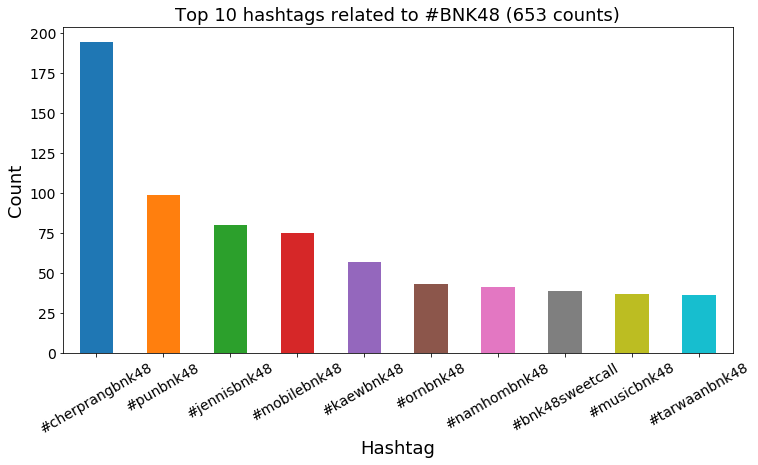

In [187]:
import time
import re
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython import display

%matplotlib inline

# record start time and set streaming period
start_time = datetime.now()
stream_period = 5  # in minutes
finish_time = start_time + timedelta(minutes=stream_period)

# create a blank Pandas DataFrame 
df = pd.DataFrame([], columns=['hashtag','time_(s)'])

# iterative streaming and plotting
while datetime.now() < finish_time:
    
    # set wait time between iteration
    wait_time = 10 # in seconds
    time.sleep(wait_time)    
    stream_time = datetime.now()
    
    # get tweets and hashtags
    tweets = s.recv(4096).decode("utf-8", errors='ignore')
    hashtags = [hashtag.lower() for hashtag in re.split('\s+', tweets) if len(hashtag)>0 and hashtag[0]=="#"]
    
    # store and count hashtags in Pandas DataFrame
    temp_df = pd.DataFrame({'hashtag':hashtags,'time_(s)':(stream_time-start_time).seconds})
    df = pd.concat([df, temp_df])
    results = df.groupby('hashtag')['hashtag'].count().sort_values(ascending=False).reset_index(name='count').head(11)
    
    # number of '#bnk48'
    bnk48_count = results[results['hashtag']=='#bnk48']['count'].values
    
    # create bar chart ranking top ten hashtags related to '#bnk48'
    fig, ax = plt.subplots(1,1,figsize=(12,6)) 
    results[results['hashtag']!='#bnk48'].plot(kind='bar', x='hashtag', y='count', legend=False, ax=ax)
    ax.set_title("Top 10 hashtags related to #BNK48 (%d counts)" % bnk48_count, fontsize=18)
    ax.set_xlabel("Hashtag", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), {"fontsize":14}, rotation=30)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # show only integer yticks
    plt.yticks(fontsize=14)
    
    # clear previous output, print start time and current time, and plot the current chart 
    display.clear_output(wait=True)
    print("start time:", start_time.strftime('%Y-%m-%d %H:%M:%S'))
    print("stream time:", stream_time.strftime('%Y-%m-%d %H:%M:%S'))
    plt.show()
    

## Ready. Set. Go!

หลังจากเรามี code ทุกอย่างเรียบร้อยแล้วก็ทำการ run ทุกอย่างตามที่เขียนไว้ในส่วน **Technical part 2** และ **Technical part 3** ได้เลยครับ

ก็จะได้ chart ออกมาประมาณนี้ โดยตัว chart จะ update ตัวเองเรื่อยๆ ตามที่ตั้งไว้

<img src="chart_example.png" alt="chart_example" style="width: 700px;"/>

เมื่อเราทำการ streaming จนพอใจแล้วก็ปิดการ streaming ด้วยคำสั่งนี้ครับ

In [190]:
# close the connection
s.close()

ปล. อย่าลืมไปปิดตัว terminal ที่รัน python script (streamingTwitterTags.py) เชื่อมต่อกับ Twitter API ด้วยนะครับ

## สรุปผลการสำรวจความนิยมของเหล่าไอดอล BNK48 แบบ real-time ในคืนวัน Valentine

ผู้เขียนได้ทำการรัน code ที่เราทำขึ้นในคืนวัน Valentine ช่วงเวลา 20.00-21.00 นะครับ

เรามาดูกันว่าสาวๆ BNK48 คนไหนบ้างที่มีชาว Twitter พูดถึงกันมากที่สุดในช่วงหัวค่ำของวันแห่งความรัก

![Animated ranking results](output.gif)

จากไฟล์ภาพนะครับ เราก็จะเห็นว่าในตอนเริ่มต้นการ streaming 

บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย บรรยาย


นอกจาก

In [188]:
ranked_hashtags = ['#cherprangbnk48','#punbnk48','#kaewbnk48','#jennisbnk48','#mobilebnk48']

df_plot = df[df['hashtag'].isin(ranked_hashtags)]
df_plot = df_plot.groupby(['time_(s)','hashtag']).size()
df_plot = df_plot.to_frame().rename(columns={0:'count'})
df_plot = df_plot.groupby('hashtag')['count'].apply(lambda x: x.cumsum())
df_plot = df_plot.to_frame().rename(columns={0:'cumsum'})
df_plot = df_plot.unstack().fillna(method='ffill').fillna(0)

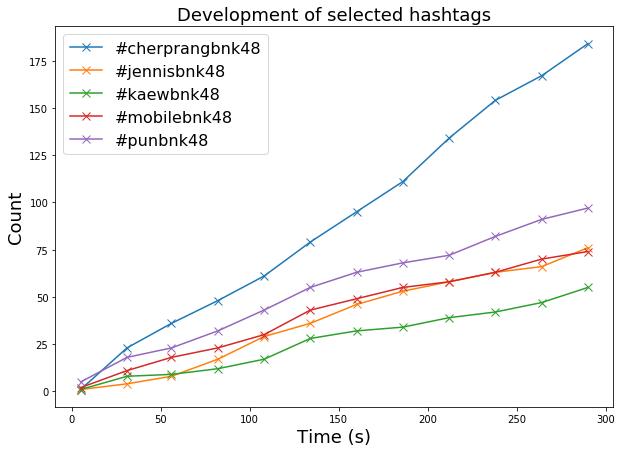

In [189]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
df_plot[::5].plot(marker='x', markersize=8, ax=ax)
ax.set_title("Development of selected hashtags", fontsize=18)
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.legend(df_plot.columns.levels[1], fontsize=16)
plt.show()

## ส่งท้าย

จบแล้วครับสำหรับการทำ code และตัวอย่างการสำรวจความนิยมของสาวๆ BNK48 โดยใช้ Twitter API + Python

เป็นไงบ้างครับ โอชิใครขึ้นแท่นสมาชิกสุดฮอทของวงบ้าง โอชิใครหลุดลำดับไปก็ชวนเพื่อนๆ ไปช่วยกันทำคะแนนความนิยมเพิ่มได้โดยการไป flood Twitter กันนะครับ XD

![otaku_power](otaku_power.jpg) 
image from https://holyonthenet.webnode.es/news/cafes-cosplay-/

หวังว่าตัวอย่างสนุกๆ นี้จะพอเป็นประโยชน์กับผู้ที่สนใจจะทำ data manipulation หรือ data streaming ด้วย (Py)Spark บ้างนะครับ

หากส่วนไหนผิดพลาดหรือข้อแนะนำเพิ่มเติมตรงไหนก็รบกวนช่วยแจ้งได้เลยนะครับ ขอบคุณครับผม